In [1]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

# Catfish Sales Data

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
url = "https://raw.githubusercontent.com/anhnguyendepocen/Time-Series-Analysis-1/master/catfish.csv"
catfish_sales = pd.read_csv(url, parse_dates=[0], index_col=0, date_parser=parser)

In [5]:
catfish_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1986-01-01 to 2012-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Total   324 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [6]:
catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239
...,...
2012-08-01,14442
2012-09-01,13422
2012-10-01,13795


## Seasonal Decompose

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

### Bu kütüphane seasonality hakkında bilgi veren bir kütüphane üzerinde çok çalışamadım henüz ama bu haliyle de faydalı görünüyor. Bize genel trendi ve seasonality i gösteriyor.

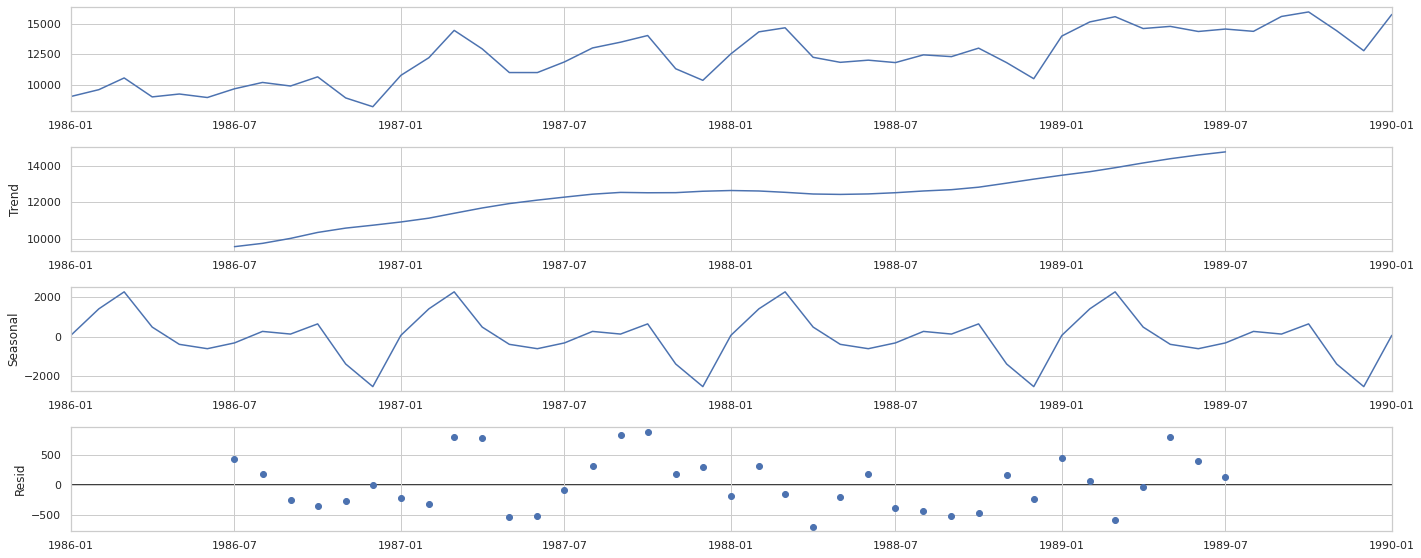

In [8]:
plt.rc('figure',figsize=(20,8))
plt.rc('font',size=15)

result = seasonal_decompose(catfish_sales.loc[:"1990-01-01"], model='additive')
fig = result.plot()

## Isolation forest

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

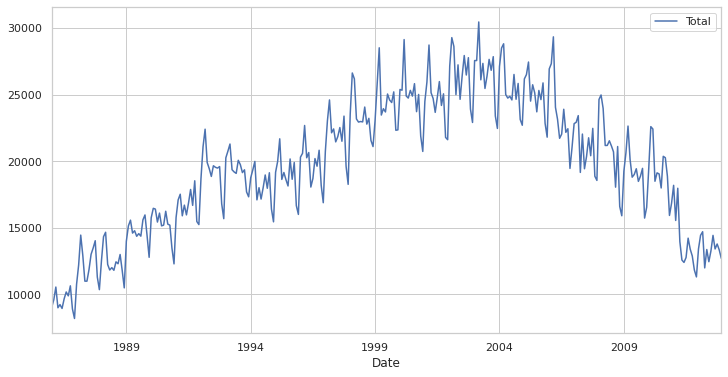

In [10]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
catfish_sales.plot()

In [11]:
url = "https://raw.githubusercontent.com/anhnguyendepocen/Time-Series-Analysis-1/master/catfish.csv"
catfish_sales = pd.read_csv(url, parse_dates=[0], index_col=0, date_parser=parser)

catfish_sales.loc["1998-12-1"]['Total'] = 10000
catfish_sales.loc["1990-12-1"]['Total'] = 23000
catfish_sales.loc["1993-3-1"]['Total'] = 30000
catfish_sales.loc["2003-3-1"]['Total'] = 35000

In [12]:
outliers_fraction = float(.01)

In [13]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(catfish_sales.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [14]:
model =  IsolationForest(contamination=outliers_fraction, n_estimators=500)
model.fit(data) 

IsolationForest(contamination=0.01, n_estimators=500)

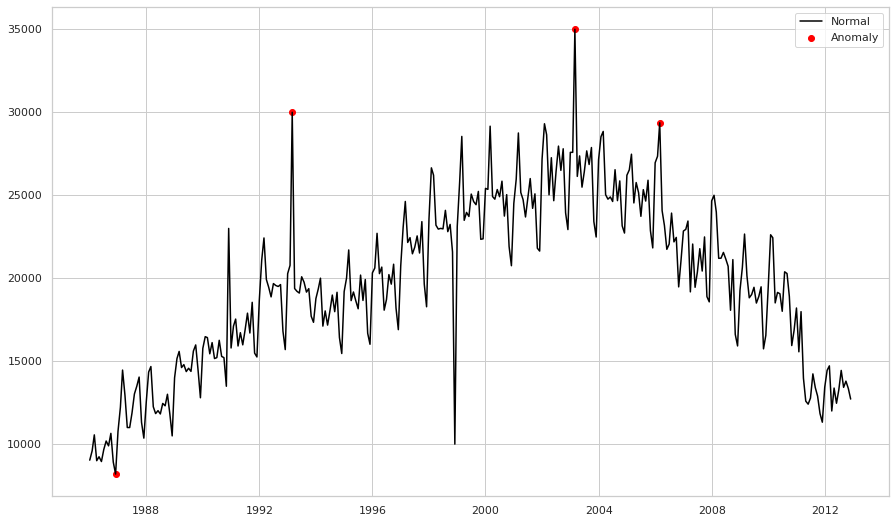

In [15]:
catfish_sales['anomaly'] = model.predict(data)

fig, ax = plt.subplots(figsize=(15,9))

a = catfish_sales.loc[catfish_sales['anomaly'] == -1, ['Total']] #anomaly

ax.plot(catfish_sales.index, catfish_sales['Total'], color='black', label = 'Normal')
ax.scatter(a.index,a['Total'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

### Isolation forest datamızın genel trendi değişmeyen örneklerde faydalı olabilir. Ama genel trend yukarıdaki gibi değişiyorsa tahminler doğru olmuyor. Yani kendi yılı içinde anormal olan verileri normal kabul ediyor. Yukarıdaki örnekte 1990, 1993 yıllarındaki 20000 üstü değerleri ve 1999 yıllındaki 10000 değerini anomali olarak görmüyor. 

## Forecasting with fbprophet

###Bu kütüphane time series analiz yapıyor. Future prediction da yapıyor.



In [131]:
from fbprophet import Prophet

In [132]:
df = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv")

In [133]:
df.tail(15)

,ds,y
2890,2016-01-06,8.352554
2891,2016-01-07,8.295798
2892,2016-01-08,8.290293
2893,2016-01-09,7.785721
2894,2016-01-10,8.281724
2895,2016-01-11,8.470730
2896,2016-01-12,8.135054
2897,2016-01-13,8.067149
2898,2016-01-14,8.023552
2899,2016-01-15,8.021913


In [134]:
df.shape

(2905, 2)

In [135]:
df.y.describe()

count    2905.000000
mean        8.138958
std         0.845957
min         5.262690
25%         7.514800
50%         7.997999
75%         8.580168
max        12.846747
Name: y, dtype: float64

In [136]:
df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


### Burada bizim cihazlardaki açık kapalı durumlarını simüle etmek için hafta sonlarını ayrı bir değişken olarak dataya ekledik

In [137]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    if date.weekday() >= 5:
        return 1
    else:
        return 0
df['is_weekend'] = df['ds'].apply(is_weekend)


In [138]:
df.head(10)

,ds,y,is_weekend
0,2007-12-10,9.590761,0
1,2007-12-11,8.519590,0
2,2007-12-12,8.183677,0
3,2007-12-13,8.072467,0
4,2007-12-14,7.893572,0
5,2007-12-15,7.783641,1
6,2007-12-16,8.414052,1
7,2007-12-17,8.829226,0
8,2007-12-18,8.382518,0
9,2007-12-19,8.069655,0


### Ayrıca "is_weekend" değişkenini de tahmin yaparken regressor olarak kullansın diye onu da modele ekliyoruz.

In [139]:
m = Prophet()
m.add_regressor("is_weekend")
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [140]:
future = m.make_future_dataframe(periods=365, freq="D")
future['is_weekend'] = future['ds'].apply(is_weekend)

forecast = m.predict(future)
future.tail(7)

,ds,is_weekend
3263,2017-01-13,0
3264,2017-01-14,1
3265,2017-01-15,1
3266,2017-01-16,0
3267,2017-01-17,0
3268,2017-01-18,0
3269,2017-01-19,0


In [141]:
forecast = m.predict(future)
forecast[['ds', 'is_weekend', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,is_weekend,yhat,yhat_lower,yhat_upper
3265,2017-01-15,-0.344812,8.208084,7.563545,8.927133
3266,2017-01-16,0.000000,8.518418,7.794333,9.236192
3267,2017-01-17,0.000000,8.291048,7.579186,9.040958
3268,2017-01-18,0.000000,8.117495,7.429917,8.827339
3269,2017-01-19,0.000000,8.137326,7.399450,8.910749


### Aşağıdaki sütunlar modelin kendi oluşturduğu sütünlar bunlarla tahmin yapıp grafikleri çizdiriyor.

In [142]:
forecast.columns  

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'extra_regressors_additive', 'extra_regressors_additive_lower', 'extra_regressors_additive_upper', 'is_weekend', 'is_weekend_lower', 'is_weekend_upper', 'monthly', 'monthly_lower', 'monthly_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'], dtype='object')

### Aşağıdaki grafikte siyah noktalar gerçek veriler, mavi alanlar ise tahmin sınırlarını gösteriyor. Mavi alandan uzaklaşan veriler anormal kabul edilebilir. 

In [144]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast, figsize=(1300, 700))

### Aşağıdaki grafikte verilerimizin hafta sonu ve iş günleri arasındaki farklılığını görüyoruz.

In [145]:
import plotly.express as px

fig = px.line(df[:365], y=["y"], color=["weekend" if x == 1 else "workday" for x in df["is_weekend"][:365]])

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="white",
)
fig.show()

### Aşağıda Yıllık aylık ve haftalık trendleri görüyoruz. Extra regressor hafta sonlarının etkisini gösteriyor.

In [146]:
plot_components_plotly(m, forecast, figsize=(1300, 200))

### Modeli incelemek için datamızın son 365 gününü test olarak, kalanını da train olarak ayırıyoruz.

In [147]:
test_size = 365

train = df[:-test_size]
test = df[-test_size:]

In [148]:
test.columns

Index(['ds', 'y', 'is_weekend'], dtype='object')

In [149]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def train_val(model, train, test):
    y_train_pred = model.predict(train)
    y_pred = model.predict(test)
    
    scores = {"train": {"R2" : r2_score(train["y"], y_train_pred["yhat"]),
    "mae" : mean_absolute_error(train["y"], y_train_pred["yhat"]),
    "mse" : mean_squared_error(train["y"], y_train_pred["yhat"]),                          
    "rmse" : np.sqrt(mean_squared_error(train["y"], y_train_pred["yhat"]))},
    
    "test": {"R2" : r2_score(test["y"], y_pred["yhat"]),
    "mae" : mean_absolute_error(test["y"], y_pred["yhat"]),
    "mse" : mean_squared_error(test["y"], y_pred["yhat"]),
    "rmse" : np.sqrt(mean_squared_error(test["y"], y_pred["yhat"]))}}
    
    return pd.DataFrame(scores)

### Error metrikleri train ve test datasında benzer. R2 fark var overfit olabilir mi

In [150]:
train_val(m, train, test)

,train,test
R2,0.672763,0.579782
mae,0.340081,0.304780
mse,0.233735,0.219837
rmse,0.483462,0.468867


### Test datasındaki Actual veriler iler predicted verileri aşağıda çizdiriyoruz.

In [151]:
y_pred = m.predict(test)
test["predicted"] = y_pred["yhat"].values

import plotly.express as px

fig = px.line(test, y=["y", "predicted"], hover_data=["is_weekend"])

newnames = {"y": "Actual", "predicted": "Predicted"}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name], legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="white",
)
fig.show()

